#### Contents
[Import Libraries](#import_libraries)

[Load the Data](#load_the_data)

[Modeling](#modeling)
- [Set Up Features](#set-up)
- [Pairplot of features](#pairplot)
- [Target Distribution](#tar-dist)
- [Train Test Split](#split)
- [Logistic Regression](#logreg1)
- [Evaluating the Models](#eval)
- [Looking at Other Models](#others)
- [Decision Tree](#dt)
- [K-Nearest Neighbors](#knn)
- [Naive Bayes](#nb)
- [Support Vector Machine](#svm)
- [XGBoost](#xgb1)
- [Bagging Decision Trees](#bdt)
- [Random Forest](#rf)

[Model Comparison](#modelcomp)

[Model Tuning and Feature Selection](#tuning)
- [Logistic Regression Tuning](#lr-tuning)
- [XGBoost Tuning](#xgb-tuning)

[Visualizing Results](#viz)

<a class="anchor" id="import_libraries"></a>
## Import Libraries

In [1]:
# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from six import StringIO
#from sklearn.externals.six import StringIO
from xgboost import XGBClassifier

# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Oswald']
font = {'size'   : 12}
plt.rc('font', **font)

%precision 5

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


'%.5f'

<a class="anchor" id="load_the_data"></a>
## Load the Data

In [2]:
# Bring in pickled data file with cleaned data

# with open('data/clean_df_modeling.pickle', 'rb') as read_file:
with open('data/clean_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)
# with open('data/df.pickle','rb') as read_file:
#     df = pickle.load(read_file)

In [3]:
df.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'status_bool',
       'company_name', 'avg_time_bw_rounds', 'avg_raise_usd',
       'time_bw_first_rounds', 'cat_list', 'country', 'state',
       'float_avg_time_bw_rounds', 'float_time_bw_first_rounds'],
      dtype='object')

<a class="anchor" id="modeling"></a>
## Modeling

<a class="anchor" id="set-up"></a>
### Set up features and target=status_bool

In [4]:
# Category Dummies
cat_dummies = pd.get_dummies(df['cat_list'], drop_first=True)
# Country Dummies
country_dummies = pd.get_dummies(df['country'], drop_first=True)
# State Dummies
state_dummies = pd.get_dummies(df['state'], drop_first=True)

In [5]:
df['state'].unique()

array(['0_other_state', 'CA', 'WA', '2', 'MA', 'unknown', 'FL', 'TX',
       'NY', 'IL', 'H9', 'PA', '7'], dtype=object)

In [6]:
# Create dummy variables for category, country, and state

X_col_nodummies = [
    'funding_rounds', 'float_avg_time_bw_rounds', 'avg_raise_usd',
    'float_time_bw_first_rounds'
]
X_nodummies = df[X_col_nodummies]

In [7]:
# Merge in dummies to feature matrix
X = X_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    country_dummies, left_index=True, right_index=True).merge(state_dummies,
                                                              left_index=True,
                                                              right_index=True)

# Add intercept column
X['intercept'] = 1

In [8]:
# Target
y = df.status_bool

In [9]:
# Export for visualizations in Tableau
df.to_csv('data/df.csv')

<a class="anchor" id="pairplot"></a>
### Look at data on pairplot, inspect for feature interactions

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Oswald


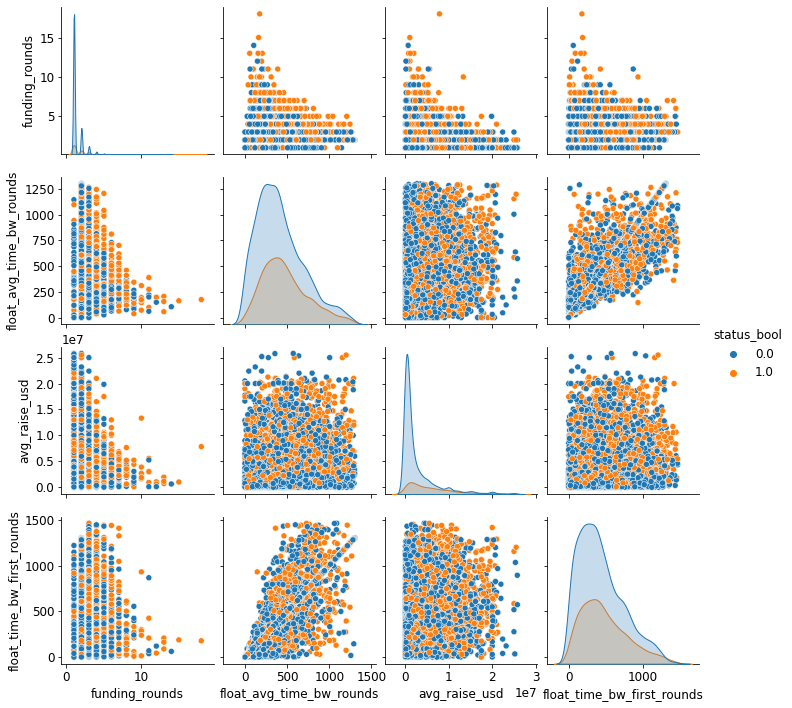

In [10]:
sns.pairplot(df[X_col_nodummies + ['status_bool']], hue='status_bool')

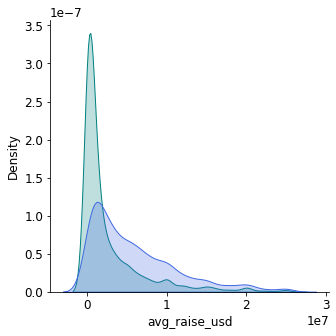

In [11]:
# Take a closer look at some of the features

# Average raise amount
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['avg_raise_usd'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['avg_raise_usd'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.savefig('web_app/templates/img/avg_raise_kse.png')

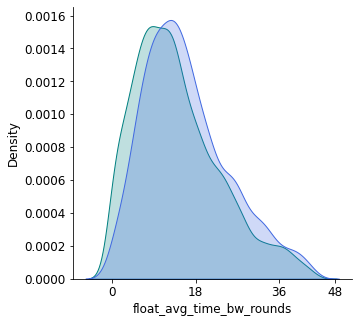

In [12]:
# average time between rounds
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 0]['float_avg_time_bw_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 1]['float_avg_time_bw_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('web_app/templates/img/avg_time_kde.png')

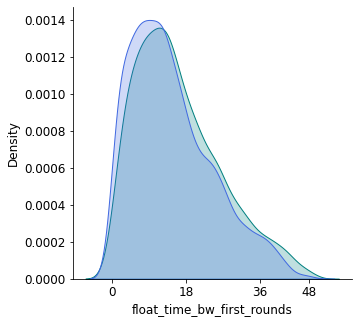

In [13]:
# average time between rounds
plt.figure(figsize=(5, 5))
sns.kdeplot(df[df.status_bool == 1]['float_time_bw_first_rounds'],
            label='Fail',
            shade=True,
            color='teal')
sns.kdeplot(df[df.status_bool == 0]['float_time_bw_first_rounds'],
            label='Success',
            shade=True,
            color='royalblue')
sns.despine()
plt.xticks((0, 540, 1080, 1440), ('0', '18', '36', '48'))
plt.savefig('web_app/templates/img/first_time_kde.png')

<a class="anchor" id="tar-dist"></a>
### Inspect distribution of targets

In [14]:
# Count target values
target_count = y.value_counts()

# # print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 24003
Class 1: 5419
Proportion: 4.43 : 1
Percentage of Majority Class: 81.580000


The dataset is not very imbalanced, so we should not need to oversample the minority class, but later on we will try oversampling to see how it affects the results

In [15]:
target_count

0.0    24003
1.0     5419
Name: status_bool, dtype: int64

<a class="anchor" id="split"></a>
### Train test split + standardize the data

In [16]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [17]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

<a class="anchor" id="logreg1"></a>
Going to test out a bunch of classification algorithms to see which performs the best then try to optimize the top ones by tuning their hyperparameters as well as feature selection and any additional feature engineering
### Logistic Regression

In [18]:
X_train_scaled = np.nan_to_num(X_train_scaled)
y_train = np.nan_to_num(y_train)

# Instantiate model
logreg = LogisticRegression(C=10, solver='lbfgs')

# Fit model to the training data
logreg.fit(X_train_scaled, y_train)

# Pickle this for later
joblib.dump(logreg, 'logreg.pkl')

['logreg.pkl']

In [19]:
X_test_scaled = np.nan_to_num(X_test_scaled)
# Calculate ROC curve for logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

# Calculate area under the curve (AUC) for ROC
auc_lr = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

<a class="anchor" id="eval"></a>
### Evaluating the Models

#### Calculating f_beta
The F-beta score weights recall more than precision by a factor of beta

Weigh recall more heavily than precision because in the case of venture capital investments, it is worse to miss out on a potential unicorn investment (10-100X return) (type II error - false negative) than to invest in a dud (1X loss) (type 1 error - false positive), however we won't place all weight on recall as it is still valuable for a VC firm to distinguish itself by reducing the amount of "duds" it invests in

If viewing from the prospective of a founder, they would prioritize precision since starting a company requires a lot of time and effort, they want to really improve the likelihood of starting a successful company

Find the probability threshold which optimizes the f_beta score

In [20]:
def fbeta(model, y_test=y_test, X_test=X_test_scaled):
    """
    Calculate the probability threshold that yields the highest f_beta value
    input: fitted model, y_test, X_test
    """
    prob_thresholds = np.arange(0, 1, 0.005)
    fbeta = []
    for prob in prob_thresholds:
        fbeta.append(
            fbeta_score(y_test,
                        model.predict_proba(X_test)[:, 1] > prob, beta=3)) # beta=3
    all_fbeta = list(zip(prob_thresholds, fbeta))
    best_fbeta = max(list(zip(prob_thresholds, fbeta)), key=lambda x: x[1])
    print(
        'Probability that yields the best fbeta score is {} with fbeta={:5f}'.
        format(best_fbeta[0], best_fbeta[1]))
    return all_fbeta, best_fbeta

In [21]:
# Calculate fbeta for logistic regression
all_fbeta_lr, best_fbeta_lr = fbeta(logreg, y_test=y_test, X_test=X_test_scaled)
p_thresh = best_fbeta_lr[0]

Probability that yields the best fbeta score is 0.07 with fbeta=0.709317


#### Precision Recall Curve (with f_beta)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Oswald


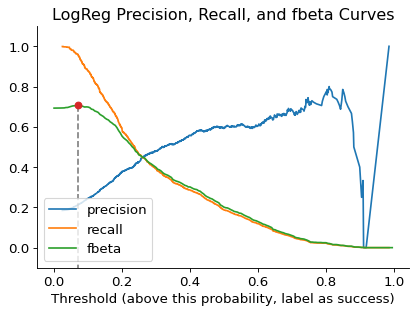

In [22]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_lr))[0],
         list(zip(*all_fbeta_lr))[1],
         label='fbeta')
plt.plot([best_fbeta_lr[0], best_fbeta_lr[0]], [-1, best_fbeta_lr[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_lr[0], best_fbeta_lr[1], 'o')
plt.ylim([-0.1, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)')
plt.title('LogReg Precision, Recall, and fbeta Curves')
sns.despine()
plt.savefig('web_app/templates/img/init_lr_precisionrecallcurve.png')
plt.savefig('web_app/templates/img/init_lr_precisionrecallcurve.svg')

In [23]:
lr_coefs = list(zip(X.columns, logreg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .07]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]), reverse=True)
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)
lr_top_coefs_df.to_csv('data/lr_coefs.csv')

/tmp/ipykernel_2155/2053558292.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


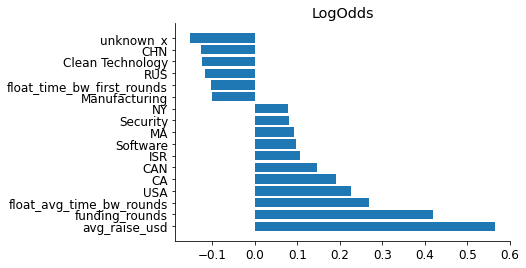

In [24]:
plt.barh([x[0] for x in lr_top_coefs], width=[x[1] for x in lr_top_coefs])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

<a class="anchor" id="others"></a>
## Looking at other models
<a class="anchor" id="dt"></a>
### Decision Tree
Similar to logistic regression, decision tree is very easy to interpret, so this will be another way to look into the feature importances.

Decision tree does not require data to be scaled

In [25]:
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

# Calculate fbeta for decision tree
all_fbeta_dt, best_fbeta_dt = fbeta(dt,
                                    X_test=X_test)  # not scaled data for dt

# Calculate ROC Score and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # not scaled data for dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

Probability that yields the best fbeta score is 0.06 with fbeta=0.702085


In [26]:
%pip install graphviz

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
# # This allows us to make a decision tree real fast directly in the notebook!
# dot_data = StringIO()
# export_graphviz(dt,
#                 out_file=dot_data,
#                 feature_names=X.columns.tolist(),
#                 filled=True,
#                 rounded=True, 
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('web_app/templates/img/decision_tree.png')
# Image(graph.create_png())

Blue is a 1, red is a 0

In [28]:
# Feature importance

pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)[0:15]

,feature,importance
2,avg_raise_usd,0.609897
0,funding_rounds,0.208933
38,USA,0.072246
42,CA,0.027408
1,float_avg_time_bw_rounds,0.027058
25,Software,0.020503
3,float_time_bw_first_rounds,0.012185
7,Biotechnology,0.009428
30,CHN,0.006835
36,ISR,0.005506


<a class="anchor" id="knn"></a>
### KNN
While KNN requires nearly zero time to train, it takes a long time to build predictions and is used less often than other classifiers in industry. That said, this project is an exercise in understanding the various classification algorithms so it is used below for completeness

In [29]:
# Instantiate Model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit Model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [30]:
# Calculate fbeta for KNN
all_fbeta_knn, best_fbeta_knn = fbeta(knn,
                                      X_test=X_test_scaled)  # scaled for knn

# Calculate ROC Score and AUC for knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn
auc_knn = roc_auc_score(
    y_test,
    knn.predict_proba(X_test_scaled)[:, 1])  # scaled for knn

Probability that yields the best fbeta score is 0.0 with fbeta=0.618872


<a class="anchor" id="nb"></a>
### Naive Bayes
#### Bernoulli
This works best on binary features

In [31]:
nbb = BernoulliNB()
nbb.fit(X_train_scaled, y_train)

BernoulliNB()

In [32]:
# Calculate fbeta for Naive Bayes Bernoulli
all_fbeta_nbb, best_fbeta_nbb = fbeta(nbb,
                                      X_test=X_test_scaled)  # scaled for nbb

# Calculate ROC Score and AUC for Naive Bayes Bernoulli
fpr_nbb, tpr_nbb, thresholds_nbb = roc_curve(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # scaled for nbb
auc_nbb = roc_auc_score(
    y_test,
    nbb.predict_proba(X_test_scaled)[:, 1])  # scaled for nbb

Probability that yields the best fbeta score is 0.015 with fbeta=0.701095


#### Gaussian
This works better on continuous features

In [33]:
nbg = GaussianNB()
nbg.fit(X_train_scaled, y_train)

GaussianNB()

In [34]:
# Calculate fbeta for Naive Bayes Gaussian
all_fbeta_nbg, best_fbeta_nbg = fbeta(nbg,
                                      X_test=X_test_scaled)  # scaled for nbg

# Calculate ROC Score and AUC for Naive Bayes Gaussian
fpr_nbg, tpr_nbg, thresholds_nbg = roc_curve(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # scaled for nbg
auc_nbg = roc_auc_score(
    y_test,
    nbg.predict_proba(X_test_scaled)[:, 1])  # scaled for nbg

Probability that yields the best fbeta score is 0.0 with fbeta=0.693050


NOTE: Multinomial Naive Bayes not tested here - this works better on count-based features - only one of my features is count-based (number of rounds) - this algorithm cannot handle negative data

<a class="anchor" id="svm"></a>

### Support Vector Machine

In [35]:
svm_model = svm.SVC(kernel="linear", probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True)

In [36]:
# Calculate fbeta for SVM
all_fbeta_svm_model, best_fbeta_svm_model = fbeta(
    svm_model, X_test=X_test_scaled)  # scaled for SVM

# Calculate ROC Score and AUC for SVM
fpr_svm_model, tpr_svm_model, thresholds_svm_model = roc_curve(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM
auc_svm_model = roc_auc_score(
    y_test,
    svm_model.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM

Probability that yields the best fbeta score is 0.05 with fbeta=0.693095


<a class="anchor" id="xgb1"></a>
### XGBoost
Similar to other tree based algorithms but it uses boosting to calculate each subsequent tree which is necessarily sequential and thus takes longer to run since it cannot be parallelized

In [37]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:11:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
# Calculate fbeta for XGBoost
prob_thresholds = np.arange(0, 1, 0.005)
fbeta_xgb = []
for prob in prob_thresholds:
    fbeta_xgb.append(
        fbeta_score(y_test,
                    xgb.predict_proba(X_test)[:, 1] > prob, beta=3))
all_fbeta_xgb = list(zip(prob_thresholds, fbeta_xgb))
best_fbeta_xgb = max(list(zip(prob_thresholds, fbeta_xgb)), key=lambda x: x[1])
print('Probability that yields the best fbeta score is {} with fbeta={:5f}'.
      format(best_fbeta_xgb[0], best_fbeta_xgb[1]))

# Calculate ROC Score and AUC for Naive Bayes Gaussian
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # not scaled for xgboost
auc_xgb = roc_auc_score(
    y_test,
    xgb.predict_proba(X_test)[:, 1])  # not scaled for xgboost

Probability that yields the best fbeta score is 0.06 with fbeta=0.720115


In [39]:
xgb_feats = sorted(list(zip(X.columns, xgb.feature_importances_)),
                   key=(lambda x: x[1]),
                   reverse=True)

<a class="anchor" id="bdt"></a>
### Bagging Decision Trees
Ensemble of decision trees using bootstrapped samples from the training set

In [40]:
bag_dt = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           bootstrap=True,
                           oob_score=True,
                           random_state=1234,
                           n_jobs=-1)
# fit
bag_dt.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=1234)

In [41]:
# Calculate fbeta for Bagging Decision Trees
all_fbeta_bag_dt, best_fbeta_bag_dt = fbeta(
    bag_dt, X_test=X_test)  # not scaled for bag_dt

# Calculate ROC Score and AUC for bag dt
fpr_bag_dt, tpr_bag_dt, thresholds_bag_dt = roc_curve(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # not scaled for bag dt
auc_bag_dt = roc_auc_score(
    y_test,
    bag_dt.predict_proba(X_test)[:, 1])  # not scaled for bag dt

Probability that yields the best fbeta score is 0.0 with fbeta=0.703987


<a class="anchor" id="rf"></a>
### Random Forest
Similar to bagging with decision trees, except at each split in a tree only a subset of the total number of features is considered, thus introducing further randomness and helping to decorellate the trees

In [42]:
# Instantiate Model
rf = RandomForestClassifier(n_estimators=500,
                            bootstrap=True,
                            oob_score=True,
                            random_state=1234,
                            n_jobs=-1)

# fit
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=1234)

In [43]:
# Calculate fbeta for Random Forest
all_fbeta_rf, best_fbeta_rf = fbeta(rf, X_test=X_test)  # not scaled for rf

# Calculate ROC Score and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test,
    rf.predict_proba(X_test)[:, 1])  # not scaled for rf
auc_rf = roc_auc_score(y_test,
                       rf.predict_proba(X_test)[:, 1])  # not scaled for rf

Probability that yields the best fbeta score is 0.0 with fbeta=0.700881


In [44]:
# Feature importance

rf_feats = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Look at top 10 features
rf_feats[0:10]

,feature,importance
2,avg_raise_usd,0.442447
1,float_avg_time_bw_rounds,0.104229
3,float_time_bw_first_rounds,0.100990
0,funding_rounds,0.051498
38,USA,0.016587
42,CA,0.015953
25,Software,0.012490
7,Biotechnology,0.011706
20,Mobile,0.010833
4,Advertising,0.009672


<a class="anchor" id="modelcomp"></a>
## Model Comparison

In [45]:
models = ['lr', 'dt', 'knn', 'nbb', 'nbg', 'svm', 'xgb', 'bag_dt', 'rf']
model_aucs = [
    auc_lr, auc_dt, auc_knn, auc_nbb, auc_nbg, auc_svm_model, auc_xgb,
    auc_bag_dt, auc_rf
]
model_fbetas = [
    best_fbeta_lr[1], best_fbeta_dt[1], best_fbeta_knn[1], best_fbeta_nbb[1],
    best_fbeta_nbg[1], best_fbeta_svm_model[1], best_fbeta_xgb[1],
    best_fbeta_bag_dt[1], best_fbeta_rf[1]
]
model_names = [
    'Logistic Regression', 'Decision Tree', 'KNN', 'Bernoulli Naive Bayes',
    'Gaussian Naive Bayes', 'Support Vector Machine', 'XGBoost',
    'Bagged Decision Tree', 'Random Forest'
]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Oswald


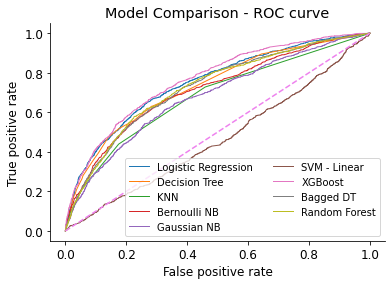

In [46]:
# Plot ROC Curves

plt.plot(fpr_lr, tpr_lr, lw=1, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNN')
plt.plot(fpr_nbb, tpr_nbb, lw=1, label='Bernoulli NB')
plt.plot(fpr_nbg, tpr_nbg, lw=1, label='Gaussian NB')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')
plt.plot(fpr_bag_dt, tpr_bag_dt, lw=1, label='Bagged DT')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')

plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()
plt.savefig('web_app/templates/img/model_comp_roc.svg')
plt.savefig('web_app/templates/img/model_comp_roc.png')

In [47]:
# Print AUC Scores
for model in list(zip(model_names, model_aucs)):
    print("ROC AUC score = {:3f} for {}".format(model[1], model[0]))

ROC AUC score = 0.748481 for Logistic Regression
ROC AUC score = 0.730520 for Decision Tree
ROC AUC score = 0.679017 for KNN
ROC AUC score = 0.711258 for Bernoulli Naive Bayes
ROC AUC score = 0.678833 for Gaussian Naive Bayes
ROC AUC score = 0.464064 for Support Vector Machine
ROC AUC score = 0.763290 for XGBoost
ROC AUC score = 0.722796 for Bagged Decision Tree
ROC AUC score = 0.724217 for Random Forest


In [48]:
# Print fbeta Scores
for model in list(zip(model_names, model_fbetas)):
    print("f_beta score = {:3f} for {}".format(model[1], model[0]))

f_beta score = 0.709317 for Logistic Regression
f_beta score = 0.702085 for Decision Tree
f_beta score = 0.618872 for KNN
f_beta score = 0.701095 for Bernoulli Naive Bayes
f_beta score = 0.693050 for Gaussian Naive Bayes
f_beta score = 0.693095 for Support Vector Machine
f_beta score = 0.720115 for XGBoost
f_beta score = 0.703987 for Bagged Decision Tree
f_beta score = 0.700881 for Random Forest


The best performance is seen in XGBoost. We'll hone in on this model as well as Logistic Regression, which also performed well and is highly interpretable to narrow down the list of features and optimize the predictive power of the models

<a class="anchor" id="tuning"></a>
## Model Tuning and Feature Selection

Look at the models that performed the best and tune their hyperparameters to improve performance further
For logistic regression, use regularization to narrow down the list of features
For tree based models, look at the feature importance to select the most important features

<a class="anchor" id="lr-tuning"></a>
### Logistic Regression Tuning
First - look at logistic regression model - try to optimize its hyperparameters and experiment with regularization to evaluate feature importance and feature collinearity

Try running a model with high regularization to see which coefficients go to zero

In [49]:
lr_reg = LogisticRegression(solver='saga',
                            C=0.1,
                            penalty='elasticnet',
                            l1_ratio=0.95)
lr_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, l1_ratio=0.95, penalty='elasticnet', solver='saga')

In [50]:
# Look at coefficients
lr_reg_coefs = pd.DataFrame(sorted(list(zip(X.columns, lr_reg.coef_[0])),
                                   key=(lambda x: x[1]),
                                   reverse=True),
                            columns=['Feature', 'Coefficient'])
lr_reg_coefs

,Feature,Coefficient
0,avg_raise_usd,0.560006
1,funding_rounds,0.417280
2,USA,0.232186
3,float_avg_time_bw_rounds,0.215359
4,CA,0.184846
5,CAN,0.144966
6,ISR,0.104253
7,Software,0.096253
8,MA,0.087535
9,Security,0.079356


There are a lot of features with really low or zero coefficients - we can simplify the model by only keeping the important features without costing model performance

In [51]:
# Only select features with strong coefficients
X_sel_cols = list(lr_reg_coefs[abs(lr_reg_coefs['Coefficient']) > 0.05]
                  ['Feature'])  # Only keep features with higher coefficients
X_sel_cols.append('Mobile')
X_sel_cols.append('Advertising')
X_sel_cols.append('Finance')
X_sel_cols.append('intercept')

In [52]:
# Save column names
joblib.dump(X_sel_cols, 'X_sel_cols.pkl')

['X_sel_cols.pkl']

In [53]:
X_sel_cols_reorder = [
    'funding_rounds', 'float_time_bw_first_rounds', 'float_avg_time_bw_rounds',
    'avg_raise_usd', 'Advertising', 'Apps', 'Biotechnology',
    'Clean Technology', 'Education', 'Enterprise Software', 'Finance',
    'Hardware + Software', 'Manufacturing', 'Mobile', 'Software', 'CAN', 'CHN',
    'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'
]

In [54]:
X_sel = X[X_sel_cols_reorder]

In [55]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=40, stratify=y)

In [56]:
# Standardize the data with new scaler for selected columns

scaler_sel = StandardScaler()
scaler_sel.fit(X_sel_train.values)
# Save scaler for later
# joblib.dump(scaler_sel,'scaler_sel.pkl');
with open("scaler_sel.pkl", "wb") as f:
    pickle.dump(scaler_sel, f)

In [57]:
# Fit the scaler using the training data and scale it
X_sel_train_scaled = pd.DataFrame(scaler_sel.transform(X_sel_train.values),
                                  columns=X_sel_cols_reorder)

# Scale the test data
X_sel_test_scaled = pd.DataFrame(scaler_sel.transform(X_sel_test.values),
                                 columns=X_sel_cols_reorder)

In [58]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'],
      dtype='object')

In [59]:
scaler_sel.transform(np.array(list(X_sel_test.iloc[1].values)).reshape(1, -1))

array([[ 0.59971,  1.04023,  1.16499,  3.31182, -0.21727, -0.12827,
        -0.2667 , -0.15569, -0.1581 , -0.17183, -0.15993,  6.69267,
        -0.14428, -0.255  , -0.34573, -0.16932, -0.15824, -0.12161,
        -0.10085,  0.8777 ,  2.02269, -0.12232, -0.19673, -0.24297,
         0.     ]])

In [60]:
# Try different values for C
c_vals = np.arange(0.1, 1.5, 0.1)

paramgrid = {'C': c_vals, 'penalty': ['l1', 'l2']}

# Define fold parameters
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
X_sel_train_scaled = np.nan_to_num(X_sel_train_scaled)
y_sel_train = np.nan_to_num(y_sel_train)

#X_train_scaled = np.nan_to_num(X_train_scaled)
#y_train = np.nan_to_num(y_train)

# Instantiate model
lr_sel = GridSearchCV(LogisticRegression(solver='saga'),
                      paramgrid,
                      cv=kf,
                      scoring='recall')

# Fit model to the training data
lr_sel.fit(X_sel_train_scaled, y_sel_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(solver='saga'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4]),
                         'penalty': ['l1', 'l2']},
             scoring='recall')

In [62]:
# Get tuned model params
lr_tuned = lr_sel.best_estimator_
lr_tuned

LogisticRegression(C=0.7000000000000001, solver='saga')

In [63]:
y_sel_test = np.nan_to_num(y_sel_test)
X_sel_test_scaled = np.nan_to_num(X_sel_test_scaled)

# Calculate area under the curve (AUC) for ROC
auc_lr_sel = roc_auc_score(y_sel_test,
                           lr_tuned.predict_proba(X_sel_test_scaled)[:, 1])
# Calculate fbeta
fbeta(lr_tuned, X_test=X_sel_test_scaled)

print('AUC = {}'.format(auc_lr_sel))

Probability that yields the best fbeta score is 0.065 with fbeta=0.704858
AUC = 0.7389981984073122


Performance of the Logistic Regression improved slightly in AUC score

### Save Logistic Regression Model for use in flask app

In [64]:
# Create an attribute for the feature names
lr_tuned.feature_names = X_sel.columns
lr_tuned.target_names = ['Fail', 'Success']

In [65]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'],
      dtype='object')

In [66]:
lr_tuned.feature_display_names = [
    'Number of Funding Rounds', 'Time Between First Rounds (months)',
    'Average Time Between Rounds (months)', 'Average Raise Amount ($)',
    'Advertising', 'Apps', 'Biotechnology', 'Clean Technology', 'Education',
    'Enterprise Software', 'Finance', 'Hardware + Software', 'Manufacturing',
    'Mobile', 'Software', 'Canada', 'China', 'Israel', 'Russia',
    'United States', 'California', 'Illinois', 'Massachusetts', 'New York',
    'int'
]

In [67]:
# Pickle this for later
with open("lr_tuned.pkl", "wb") as f:
    pickle.dump(lr_tuned, f)

#### Interpreting Coefficients and Intercept

In [68]:
# Intercept
lr_tuned.intercept_[0]

-1.713910659873318

In [69]:
# convert intercept log-odds to probability
logodds = lr_tuned.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob[0]
print(
    'All else considered, companies that make it past their\
    first funding round, probability of success is {:.2f}%'
    .format(100 * prob[0]))

All else considered, companies that make it past their    first funding round, probability of success is 15.27%


/tmp/ipykernel_2155/1115689788.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


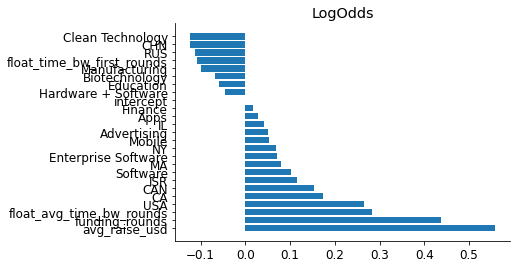

In [70]:
lr_tuned_coefs = pd.DataFrame(sorted(list(zip(X_sel.columns,
                                              lr_tuned.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])
lr_tuned_coefs['Odds'] = np.exp(lr_tuned_coefs.Coefficient)

# Plot coefficients
plt.barh(lr_tuned_coefs['Feature'], width=lr_tuned_coefs['Coefficient'])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

# Save coefficients for plotting in Tableau
with open("lr_tuned_coefs.pkl", "wb") as f:
    pickle.dump(lr_tuned_coefs, f)

In [71]:
df['float_time_bw_first_rounds'].std()

306.4568756794417

In [72]:
lr_tuned_coefs

,Feature,Coefficient,Odds
0,avg_raise_usd,0.557496,1.746294
1,funding_rounds,0.437207,1.548376
2,float_avg_time_bw_rounds,0.283179,1.327342
3,USA,0.265793,1.304465
4,CA,0.172603,1.188395
5,CAN,0.152530,1.164777
6,ISR,0.114373,1.121170
7,Software,0.101526,1.106859
8,MA,0.080531,1.083862
9,Enterprise Software,0.069663,1.072147


<a class="anchor" id="xgb-tuning"></a>
### XGBoost Tuning
Want to optimize n_estimators and max_features and narrow down feature selection

First limit number of features by keeping features with non-zero feature importance values from the baseline XGB mdoel

In [73]:
# X_sel_cols_xgb = [feat[0] for feat in xgb_feats if feat[1] > 0]

# # Save column names
# joblib.dump(X_sel_cols_xgb, 'X_sel_cols_xgb.pkl')

# # Create new feature matrix
# X_sel_xgb = X[X_sel_cols_xgb]

In [74]:
# # Split the data with 80% to train and 20% to test
# # Stratify to ensure train and test sets have 
# # similar proportions of either target class
# X_sel_xgb_train, X_sel_xgb_test, y_sel_xgb_train, y_sel_xgb_test = train_test_split(
#     X_sel_xgb, y, test_size=0.2, random_state=40, stratify=y)


Set up hyperparameters to find the model with the best performance

In [75]:
# paramgrid = {
#     'n_estimators': [1000],
#     'max_depth': [9, 6, 9],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# # Define fold parameters
# kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [76]:
# # Instantiate model
# xgb_sel = GridSearchCV(XGBClassifier(n_jobs=-1),
#                        paramgrid,
#                        cv=kf,
#                        scoring= 'recall' )

# # Fit model to the training data 
# xgb_sel.fit(X_sel_xgb_train, y_sel_xgb_train)

In [77]:
# xgb_tuned = xgb_sel.best_estimator_

In [78]:
# # Calculate area under the curve (AUC) for ROC
# auc_xgb_tuned = roc_auc_score(y_sel_xgb_test,
#                               xgb_tuned.predict_proba(X_sel_xgb_test)[:, 1])
# # Calculate fbeta
# fbeta(xgb_tuned, X_test=X_sel_xgb_test)

# print('AUC = {}'.format(auc_xgb_tuned))

<a class="anchor" id="viz"></a>
## Visualizing Results

To contextualize the results, look at the confusion matrix and assign relative dollar amounts to false positives and negatives and true positives and negatives

Since model performances were comparable, we'll move ahead with the logistic regression model as it is the easiest to interpret

In [79]:
lr_tuned.predict(X_sel_test_scaled)

array([0., 1., 0., ..., 0., 0., 1.])

In [80]:
annots = pd.DataFrame([['TN', 'FP'], ['FN', 'TP']])
type(annots)
annots

,0,1
0,TN,FP
1,FN,TP


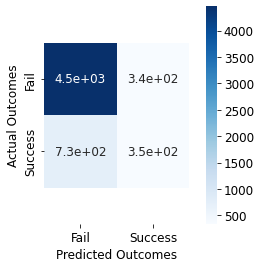

<Figure size 432x288 with 0 Axes>

In [81]:
lr_confusion = confusion_matrix(y_sel_test, [
    1 if item[1] > 0.35 else 0
    for item in lr_tuned.predict_proba(X_sel_test_scaled)
])

sns.heatmap(lr_confusion,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Fail', 'Success'],
            yticklabels=['Fail', 'Success'])  
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.xlabel('Predicted Outcomes')
plt.ylabel('Actual Outcomes')
plt.show()
plt.savefig('web_app/templates/img/confusion.png')